In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from ising import monte_carlo_metropolis
import matplotlib
from matplotlib import pyplot as plt
from timeit import timeit

# Exact results

In [3]:
# Critical value
betac = np.log(1.0 + np.sqrt(2)) / 2.0

In [4]:
def exact_mag_per_site(beta):
    if beta < betac:
        return 0
    return np.power((1 - np.power(np.sinh(2 * beta), -4)), 1.0 / 8.0)


def exact_mag_per_site_vec(betas):
    return np.array([exact_mag_per_site(beta) for beta in betas])

# Phase transition analysis

In this notebook, we will run the Monte-Carlo simulation and find the phase transition of the 2D Ising model. We will start with no external field $h = 0$ and varying the inverse temperature $\beta$.

In [5]:
def plot_lattice(lattice):
    cmap = matplotlib.colors.ListedColormap(["blue", "red"])
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.imshow(lattice, cmap=cmap, vmin=-1, vmax=1)


def plot_lattice_init_end(output):
    cmap = matplotlib.colors.ListedColormap(["blue", "red"])
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
    axs[0].imshow(output["lattice_init"], cmap=cmap, vmin=-1, vmax=1)
    axs[1].imshow(output["lattice"], cmap=cmap, vmin=-1, vmax=1)


def plot_observable(output, key, y_label=None):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
    ax.plot(output["time"], output[key])
    ax.set_xlabel("Monte-Carlo steps")
    if y_label is not None:
        ax.set_ylabel(y_label)

Let us start with large temperature configurations. We know the critical value of the Ising model in 2D.

We see that when we vary $\beta$ across the transition temperature, we go from a disordered to an ordered phase.

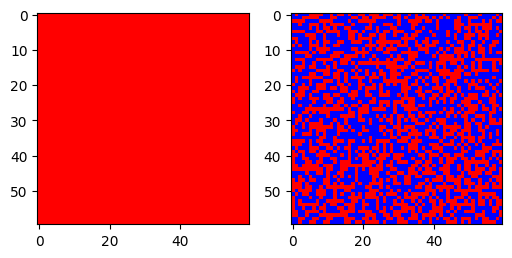

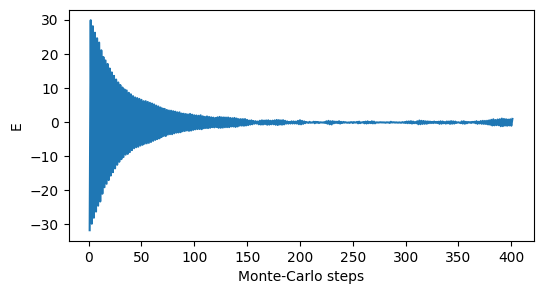

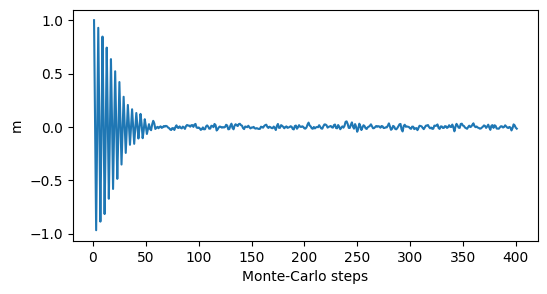

In [6]:
output = monte_carlo_metropolis(n=60, beta=0.01 * betac, h=0.0, max_steps=200, initial_state=1, method="checkerboard")
plot_lattice_init_end(output)
plot_observable(output, "benergies", y_label="E")
plot_observable(output, "magnetizations", y_label="m")

As we approach the critical temperature, we start seeing effects of the transition

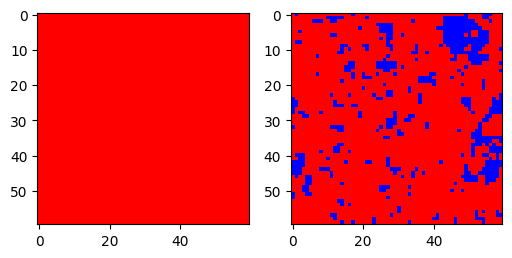

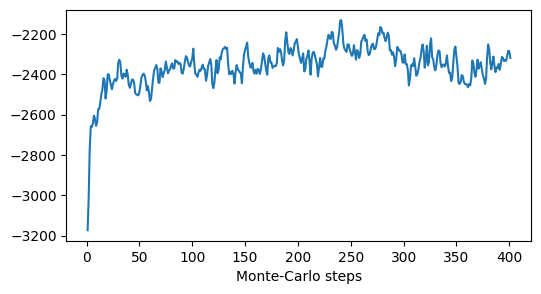

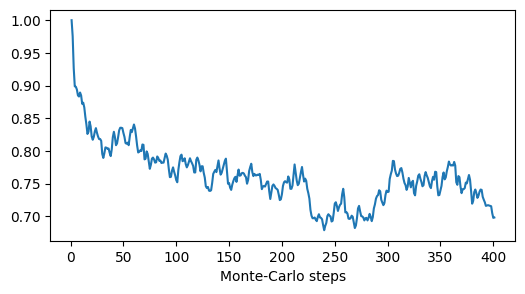

In [7]:
output = monte_carlo_metropolis(n=60, beta=1.0 * betac, h=0.0, max_steps=200, initial_state=1, method="checkerboard")
plot_lattice_init_end(output)
plot_observable(output, "benergies")
plot_observable(output, "magnetizations")

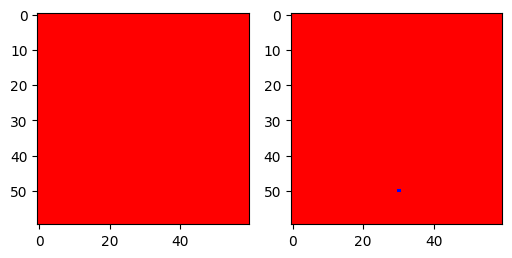

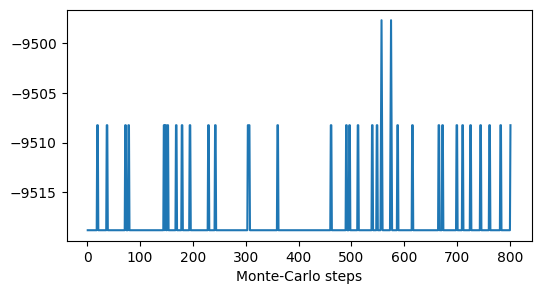

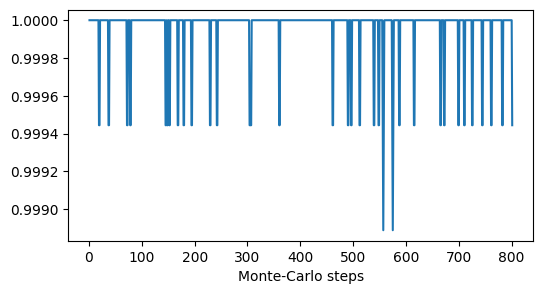

In [8]:
output = monte_carlo_metropolis(n=60, beta=3.0 * betac, h=0.0, max_steps=400, initial_state=1, method="checkerboard")
plot_lattice_init_end(output)
plot_observable(output, "benergies")
plot_observable(output, "magnetizations")

# Timing of various methods

In [9]:
methods = ["random", "checkerboard"]
outputs_test = [
    monte_carlo_metropolis(n=40, beta=0.01 * betac, h=0.0, max_steps=400, initial_state=1, method=method)
    for method in methods
]

In [10]:
times = [
    timeit(
        f"monte_carlo_metropolis(n=40, beta=0.01 * 0.441, h=0.0, max_steps=200, initial_state=1, method='{method}')",
        number=50,
        setup="from ising import monte_carlo_metropolis",
    )
    for method in methods
]

<BarContainer object of 2 artists>

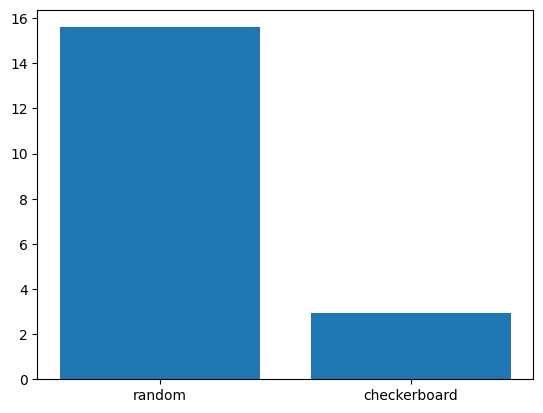

In [11]:
fig, ax = plt.subplots()
ax.bar(methods, times)

The checkerboard method is much faster as it flips N/2 spins in parallel, so we will use this method.

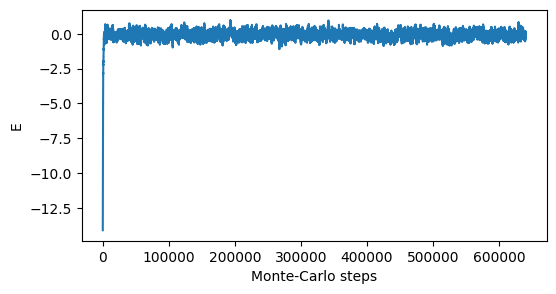

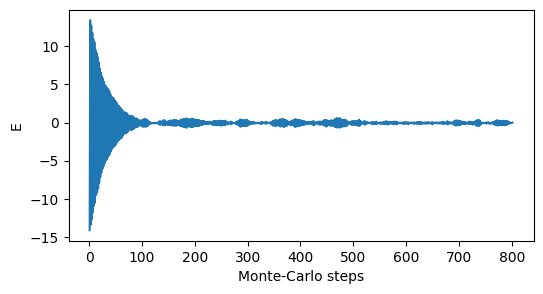

In [12]:
outputs_test[0]
plot_observable(outputs_test[0], "benergies", y_label="E")

plot_observable(outputs_test[1], "benergies", y_label="E")

# Output analysis

In [20]:
# Because of the auto-correlation time, we cherry-pick measurements every M cycles
def get_measurements_sample(arr, proportion=0.2, jumps=10):
    u = len(arr)
    v = np.floor((1 - proportion) * u).astype(int)
    return arr[v:-1:jumps]


def compute_average_magnetization_per_site(output, proportion=0.2):
    mags = output["magnetizations"]
    return np.mean(get_measurements_sample(mags))


def compute_average_magnetization_abs_per_site(output, proportion=0.2):
    mags_abs = np.abs(output["magnetizations"])
    return np.mean(get_measurements_sample(mags_abs))


def compute_average_magnetization_square_per_site(output, proportion=0.2):
    mags_square = np.power(output["magnetizations"], 2)
    return np.mean(get_measurements_sample(mags_square))


def compute_average_magnetic_susceptibility_per_site(output, proportion=0.2):
    mags = output["magnetizations"]
    beta = output["beta"]
    N = output["n"] ** 2
    return beta * np.var(get_measurements_sample(mags)) / N

## Hot initial state

Now let's see if we can check thoroughly the transition from the observables. We start by varying temperature while starting from a hot state.

In [14]:
betas = betac * np.linspace(0.01, 2.0, num=20)
outputs_hot = [monte_carlo_metropolis(n=50, beta=beta, h=0.005, max_steps=2_000, initial_state=0) for beta in betas]

Text(0, 0.5, '$|m|$')

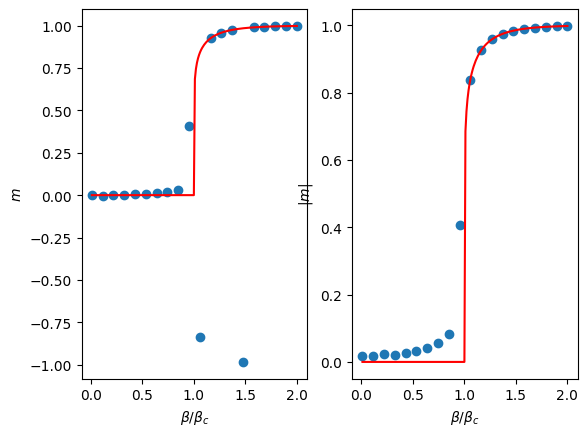

In [15]:
mags_hot = [compute_average_magnetization_per_site(output) for output in outputs_hot]
mags_abs_hot = [compute_average_magnetization_abs_per_site(output) for output in outputs_hot]

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].scatter(betas / betac, mags_hot)
betas_plot = betac * np.linspace(0.01, 2.0, num=200)
axs[0].plot(betas_plot / betac, exact_mag_per_site_vec(betas_plot), c="r")
axs[0].set_xlabel(r"$\beta/\beta_c$")
axs[0].set_ylabel(r"$m$")

axs[1].scatter(betas / betac, mags_abs_hot)
betas_plot = betac * np.linspace(0.01, 2.0, num=200)
axs[1].plot(betas_plot / betac, exact_mag_per_site_vec(betas_plot), c="r")
axs[1].set_xlabel(r"$\beta/\beta_c$")
axs[1].set_ylabel(r"$|m|$")

## Cold initial state

We now do the same but starting from a cold state (all spins up).

In [16]:
betas = betac * np.linspace(0.1, 2.0, num=40)
outputs_cold = [monte_carlo_metropolis(n=50, beta=beta, h=0.005, max_steps=2_000, initial_state=1) for beta in betas]

Text(0, 0.5, '$|m|$')

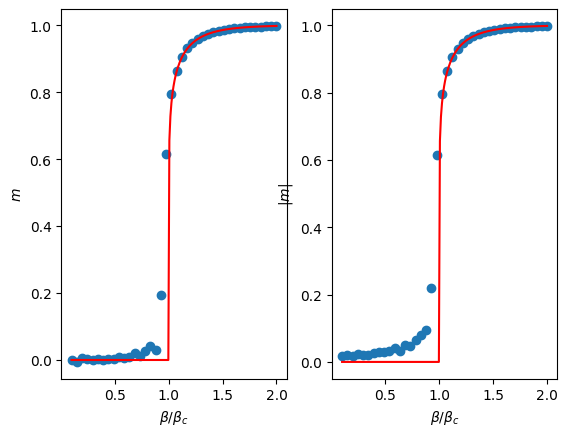

In [17]:
mags_cold = [compute_average_magnetization_per_site(output) for output in outputs_cold]
mags_abs_cold = [compute_average_magnetization_abs_per_site(output) for output in outputs_cold]

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].scatter(betas / betac, mags_cold)
betas_plot = betac * np.linspace(0.1, 2.0, num=200)
axs[0].plot(betas_plot / betac, exact_mag_per_site_vec(betas_plot), c="r")
axs[0].set_xlabel(r"$\beta/\beta_c$")
axs[0].set_ylabel(r"$m$")

axs[1].scatter(betas / betac, mags_abs_cold)
betas_plot = betac * np.linspace(0.1, 2.0, num=200)
axs[1].plot(betas_plot / betac, exact_mag_per_site_vec(betas_plot), c="r")
axs[1].set_xlabel(r"$\beta/\beta_c$")
axs[1].set_ylabel(r"$|m|$")

Here we see again the transition at the right temperature.

# Susceptibility

To compute the magnetic susceptibility, we can take the variance of the average lattice magnetization over a few thousand MC steps. Note that we are only interested in the power law behaviour in the temperature and not in overall factors which can be introduced by this sampling method.

In [48]:
betas = betac * np.linspace(0.6, stop=1.4, num=40)
outputs_cold_larger_size = [
    monte_carlo_metropolis(n=100, beta=beta, h=0.005, max_steps=4_000, initial_state=1) for beta in betas
]

Text(0, 0.5, '$m$')

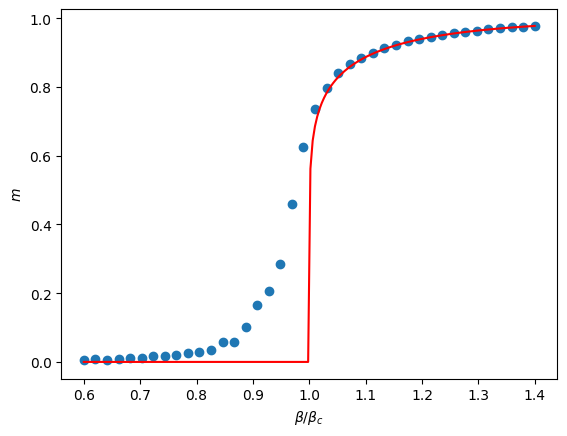

In [49]:
mags_cold_larger_size = [compute_average_magnetization_per_site(output) for output in outputs_cold_larger_size]

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(betas / betac, mags_cold_larger_size)
betas_plot = betac * np.linspace(0.6, 1.4, num=200)
ax.plot(betas_plot / betac, exact_mag_per_site_vec(betas_plot), c="r")
ax.set_xlabel(r"$\beta/\beta_c$")
ax.set_ylabel(r"$m$")

[Text(0, 0.5, '$\\chi$'), Text(0, 0.5, '$\\chi$')]

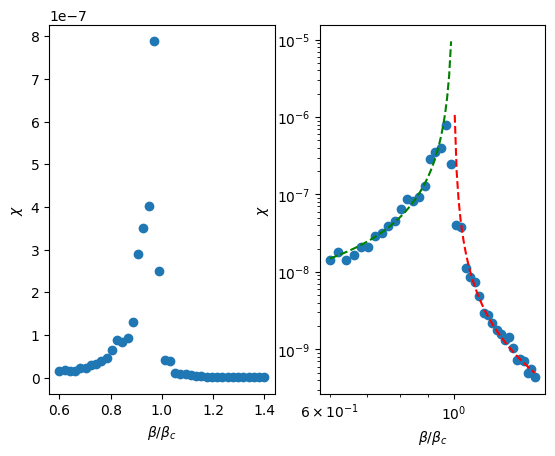

In [56]:
chi_mag_cold_larger_size = [
    compute_average_magnetic_susceptibility_per_site(output) for output in outputs_cold_larger_size
]


fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].scatter(betas / betac, chi_mag_cold_larger_size)

axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].scatter(betas / betac, chi_mag_cold_larger_size)
betas_pos = betac * np.linspace(1.005, 1.4)
betas_neg = betac * np.linspace(0.6, 0.99)
axs[1].plot(betas_pos / betac, (1e-10) * np.power(betas_pos / betac - 1, -7 / 4), "r--")
axs[1].plot(betas_neg / betac, (3e-9) * np.power(1 - betas_neg / betac, -7 / 4), "g--")

[ax.set_xlabel(r"$\beta/\beta_c$") for ax in axs]
[ax.set_ylabel(r"$\chi$") for ax in axs]

We see the power laws are good approximations!